In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('/content/drive/My Drive/Mobilenet')

In [0]:
#Importing Required libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse

In [0]:
#Setting the device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [0]:
#Augmentations on the imput images

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    #transforms.ColorJitter(brightness=1, contrast=0, saturation=0, hue=0),
    #transforms.RandomRotation(degrees=[-10,10], resample=False, expand=False, center=None, fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse truck truck plane


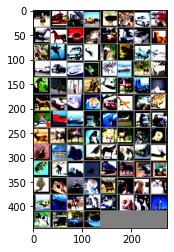

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512,512, (1024,2), 1024]  #change the depth of convolution.(Removed 3X512)

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

net = MobileNet()


In [0]:
#Setting the model on cuda

if torch.cuda.is_available():
    net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [0]:
#Training the model

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [0]:
#Testing the model

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
  # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        torch.save(net, './checkpoint/net.pth')
        best_acc = acc


In [0]:
#Implementing Train and Test for 30 epochs

for epoch in range(start_epoch, start_epoch+80):
    train(epoch)
    test(epoch)


Epoch: 0
499 500 Loss: 1.755 | Acc: 34.210% (17105/50000)
99 100 Loss: 1.511 | Acc: 45.220% (4522/10000)
Saving..

Epoch: 1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MobileNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


499 500 Loss: 1.418 | Acc: 48.186% (24093/50000)
99 100 Loss: 1.285 | Acc: 54.060% (5406/10000)
Saving..

Epoch: 2
499 500 Loss: 1.238 | Acc: 55.370% (27685/50000)
99 100 Loss: 1.080 | Acc: 61.120% (6112/10000)
Saving..

Epoch: 3
499 500 Loss: 1.091 | Acc: 61.062% (30531/50000)
99 100 Loss: 0.974 | Acc: 65.930% (6593/10000)
Saving..

Epoch: 4
499 500 Loss: 0.957 | Acc: 66.074% (33037/50000)
99 100 Loss: 0.861 | Acc: 69.720% (6972/10000)
Saving..

Epoch: 5
499 500 Loss: 0.837 | Acc: 70.398% (35199/50000)
99 100 Loss: 0.775 | Acc: 72.940% (7294/10000)
Saving..

Epoch: 6
499 500 Loss: 0.754 | Acc: 73.512% (36756/50000)
99 100 Loss: 0.713 | Acc: 74.960% (7496/10000)
Saving..

Epoch: 7
499 500 Loss: 0.692 | Acc: 75.536% (37768/50000)
99 100 Loss: 0.660 | Acc: 77.380% (7738/10000)
Saving..

Epoch: 8
499 500 Loss: 0.638 | Acc: 77.658% (38829/50000)
99 100 Loss: 0.621 | Acc: 78.780% (7878/10000)
Saving..

Epoch: 9
499 500 Loss: 0.596 | Acc: 79.004% (39502/50000)
99 100 Loss: 0.588 | Acc: 79.57

In [0]:
#Number of Parameters

def count_parameters(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print("Total_params",pytorch_total_params)
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable_params",pytorch_total_params)

In [0]:
count_parameters(net)

Total_params 2410826
Trainable_params 2410826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

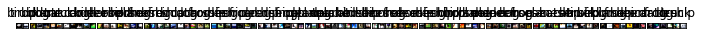

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

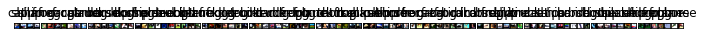

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [0]:
images = images.to(device)
labels = labels.to(device)
outputs = net(images)

In [0]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)

In [0]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

cat - 0.9857
ship - 0.9988
ship - 0.9895
plane - 0.9479
frog - 0.9984
frog - 0.9242
truck - 0.5304
frog - 0.9995
cat - 0.9703
car - 0.9947
plane - 0.9980
truck - 1.0000
cat - 0.5652
horse - 0.9998
truck - 0.9999
ship - 0.8999
dog - 0.9968
horse - 0.9995
ship - 0.9999
frog - 1.0000
horse - 0.9502
plane - 0.9792
deer - 0.9267
truck - 0.9999
deer - 0.8941
bird - 0.9984
deer - 0.9109
plane - 0.9988
truck - 0.9998
frog - 0.9987
frog - 0.9995
dog - 0.9997
deer - 0.9686
dog - 0.9859
truck - 0.9999
truck - 0.4411
deer - 0.9886
truck - 0.9387
truck - 0.9999
dog - 0.9999
deer - 0.9630
frog - 0.9999
dog - 0.9065
frog - 0.9997
plane - 0.9996
truck - 1.0000
cat - 0.9778
truck - 0.9928
horse - 0.9926
frog - 0.9906
truck - 1.0000
ship - 0.9996
truck - 0.9385
cat - 0.7662
ship - 0.9999
ship - 1.0000
horse - 0.9922
cat - 0.9060
dog - 0.7738
frog - 0.8623
horse - 0.9998
dog - 0.9158
frog - 0.9973
cat - 0.9140
frog - 0.9987
bird - 0.9984
car - 0.9960
bird - 0.9976
cat - 0.6547
horse - 0.3259
plane - 0.51

In [0]:
#Model Accuracy

total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 88.85%


In [0]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 91.4
car        - 94.8
bird       - 83.4
cat        - 78.6
deer       - 89.9
dog        - 80.4
frog       - 92.6
horse      - 88.8
ship       - 93.3
truck      - 95.3


In [0]:
#Confusion Matrix

print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           914       8         14        7         3         2         3         4         27        18        
                0.914     0.008     0.014     0.007     0.003     0.002     0.003     0.004     0.027     0.018     
car             9         948       1         0         0         1         0         0         9         32        
                0.009     0.948     0.001     0.0       0.0       0.001     0.0       0.0       0.009     0.032     
bird            39        3         834       21        27        17        27        13        7         12        
                0.039     0.003     0.834     0.021     0.027     0.017     0.027     0.013     0.007     0.012     
cat             10        8         19        786       35        80        28        7         14        13        
                0.01      0.008     0.019     0.786     0.035   

In [0]:
#Ran a lot of different models ,with different learning rates, tried different combinations of augmentations such as changing brightness, hue, jitter, and also normalisation. Experimented on different batch sizes and number of epochs. Also made architecture changes regarding number of blocks to reduce the number of parameters. 

#Decisions on how to conitnue further were made by looking at the loss. By analysing loss, we took steps like adding regualrizers to prevent overfitting. You can see all different variations in the excel sheet attached.

In [0]:
temp_check = torch.load('./checkpoint/ckpt.pth')

In [0]:
type(temp_check.get('net').get('state_dict'))

NoneType

In [0]:
with torch.no_grad():
  counter = 100
  for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs.to(device), targets.to(device)
    model = torch.load('./checkpoint/net.pth')
    outputs = model(inputs)
    # loss = criterion(outputs, targets)
    # test_loss += loss.item()
    # _, predicted = outputs.max(1)
    # total += targets.size(0)
    # correct += predicted.eq(targets).sum().item()
    softmax = torch.exp(outputs).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    print(predictions)
    break




[3 8 8 0 6 6 9 6 3 1 0 9 3 7 9 8 5 7 8 6 7 0 4 9 4 2 4 0 9 6 6 5 4 5 9 9 4
 9 9 5 4 6 5 6 0 9 3 9 7 6 9 8 9 3 8 8 7 3 5 6 7 5 6 3 6 2 1 2 3 7 0 6 8 8
 0 2 9 3 3 8 8 1 1 7 2 5 7 3 8 9 0 3 8 6 4 6 0 0 0 7]


In [0]:
checkpoint = torch.load('./checkpoint/net.pth')
#model = checkpoint['net']
#model.load_state_dict(checkpoint['state_dict'])

